In [1]:
import re
from xml.etree import ElementTree

# https://www.amcharts.com/svg-maps/?map=argentina
svg = ElementTree.parse('../data/argentinaHigh.svg')

provinces = ["Buenos Aires", "Catamarca", "Chaco", "Chubut", "Ciudad de Buenos Aires", "Córdoba", "Corrientes", "Entre Ríos", "Formosa", "Jujuy", "La Pampa", "La Rioja", "Mendoza", "Misiones", "Neuquén", "Río Negro", "Salta", "Santa Cruz", "Santiago del Estero", "Santa Fe", "San Juan", "San Luis", "Tierra del Fuego", "Tucumán"]
polygons = []
for province in provinces:
    p = svg.find('.//*[@title="%s"]' % province)
    d = p.get('d')

    points = []
    # https://developer.mozilla.org/es/docs/Web/SVG/Attribute/d
    for p in re.finditer(r'([MLlVvHhz])(-?\d+\.?\d*)(,-?\d+\.?\d*)?', d):
        if p.group(3):
            newp = [float(p.group(2)), float(p.group(3)[1:])]
        elif p.group(1) in ['H', 'h']:
            newp = [float(p.group(2)), 0]
        elif p.group(1) in ['V', 'v']:
            newp = [0, float(p.group(2))]
        if p.group(1) in ['l', 'h', 'v']:
            newp[0] += points[-1][0]
            newp[1] += points[-1][1]
        points.append(newp)

    polygons.append(points)
    print(points[:3])

[[273.73, 261.63], [273.18, 261.87], [272.58, 263.16]]
[[152.39, 121.75], [152.48, 121.93], [153.05, 124.19]]
[[266.72, 123.58], [252.25, 123.61], [243.85, 123.61]]
[[35.09, 533.72], [35.21, 533.66], [35.82, 533.14]]
[[275.97, 263.69], [275.66, 263.97], [273.81, 264.88]]
[[153.88, 271.78], [153.9, 267.76], [153.92, 251.77]]
[[252.34, 171.84], [251.99, 170.47], [252.69, 168.88]]
[[240.68, 233.76], [240.55, 233.54], [239.72, 232.39]]
[[203.64, 45.72], [203.64, 41.74], [203.68, 27.6]]
[[152.01, 6.1], [151.41, 7.57], [151.17, 8.61]]
[[184.64, 369.68], [183.6, 369.75], [183.14, 369.68]]
[[153.14, 166.04], [152.8, 166.4], [149.75, 167.28]]
[[57.2, 296.92], [57.71, 295.57], [57.51, 293.24]]
[[319.1, 110.0], [319.86, 109.89], [320.42, 110.01]]
[[34.42, 375.32], [34.7, 375.31], [35.45, 376.37]]
[[33.01, 433.3], [32.94, 432.0], [32.69, 430.57]]
[[184.46, 76.33], [174.93, 76.19], [172.29, 75.34]]
[[110.02, 613.52], [109.07, 614.47], [108.62, 615.07]]
[[152.39, 121.75], [153.69, 121.57], [154.15, 

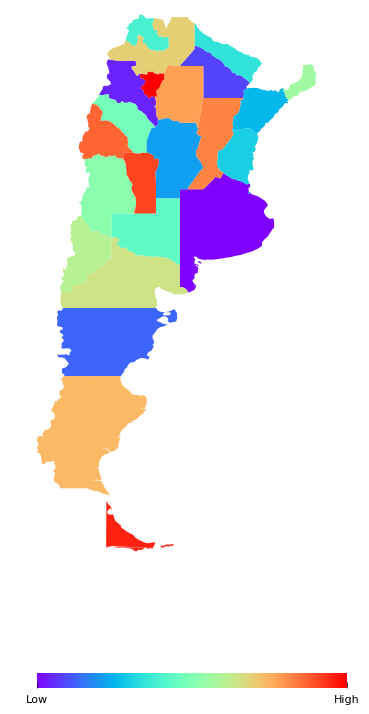

In [44]:
import numpy as np
from matplotlib import cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (4.0, 10.0), 'font.size': 8})
fig, ax = plt.subplots()
patches = []
for points in polygons:
    polygon = Polygon(points, True)
    patches.append(polygon)

colors = np.linspace(0, 1, len(patches))
p = PatchCollection(patches, cmap=cm.rainbow, alpha=1, lw=0)
ax.add_collection(p)
ax.axis([0, 400, 800, 0])
ax.set_axis_off()
p.set_array(colors)
cbar = fig.colorbar(p, ax=ax, orientation='horizontal', ticks=[0, 1])
cbar.ax.set_xticklabels(['Low', 'High'])
cbar.outline.set_visible(False)
plt.show()

In [48]:
import pandas as pd
import numpy as np
import re
from matplotlib import cm
from functools import reduce
from IPython.display import display, Markdown as md

def getPeriodDF(period, publish_date, csv_path, columns_src, columns_dst, transforms = []):
    # given a csv_path, extract src columns into dst columns by applying a transform function for a certain period name
    df_src = pd.read_csv(csv_path)
    df_dst = pd.DataFrame(columns=['period', 'publish_date']+columns_dst)
    df_dst[columns_dst] = df_src[columns_src]
    df_dst['period'] = period
    df_dst['publish_date'] = pd.to_datetime(publish_date)
    # apply custom transformations
    for transform in transforms:
        df_src, df_dst = transform(df_src, df_dst)
    return df_dst

def transformNormalize(df_src, df_dst):
    # cast to float the salary column, some datasets gets wrongly parsed due to crappy user input
    df_dst['salary'] = df_dst['salary'].astype(float)
    df_dst['age'] = df_dst['age'].astype(str)
    # normalize stack column
    re_separator = ' *, *| *; *| *\. *| *\| *| *\/ *| *- *'
    re_garbage = '"""|\*|nan|='
    df_dst['stack'] = df_dst['stack'].apply(lambda s: re.split(re_separator, re.sub(re_garbage, '', str(s)).strip().lower()))
    # munge the dataset, removing entries that we consider not realistic for our analysis
    munging_mask = (df_dst.salary > 5000) & (df_dst.salary < 300000)
    df_src = df_src.loc[munging_mask]
    df_dst = df_dst.loc[munging_mask]
    return df_src, df_dst

def transformNet2Brute(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['Bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_dst));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1/0.83
    df_dst['salary'] = net_factor * df_dst['salary']
    return df_src, df_dst

def transformNet2Brute201702(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['¿Porcentaje, bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_dst));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1/0.83
    df_dst['salary'] = net_factor * df_dst['salary']
    return df_src, df_dst

src_common_cols = [
    'Tengo',
    'Años de experiencia',
    'Años en el puesto actual',
    'Trabajo de',
    'Tecnologías que utilizás',
    'Argentina']

dst_cols = [
    'salary',
    'location',
    'gender',
    'age',
    'yoe',
    'yip',
    'role',
    'stack',
    'province']


df7 = getPeriodDF('2018.01', '2018-03-01', '../data/2018.01/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina', 'Me identifico'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute201702])

# compute the union of all the datasets as a signe pandas dataframe
df = pd.concat([df7])

# extract the list of periods
periods = df.period.unique()

# extract the list of genders
genders = df.gender.unique()

# extract the list of yoes
yoes = df.yoe.unique()

display(md('## Géneros censandos en los datasets'))
[display(md('- %s (%d total)' % (g, len(df.query('gender == "%s"' % g))))) for g in genders]
df.province.unique()

## Géneros censandos en los datasets

- Hombre (3593 total)

- Mujer (557 total)

- Otros (14 total)

array(['Catamarca', 'Chaco', 'Chubut', 'Ciudad Autónoma de Buenos Aires',
       'Córdoba', 'Corrientes', 'Entre Ríos', 'Formosa', 'GBA', 'Jujuy',
       'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén',
       'Provincia de Buenos Aires', 'Río Negro', 'Salta', 'San Juan',
       'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago del Estero',
       'Tierra del Fuego', 'Tucumán'], dtype=object)

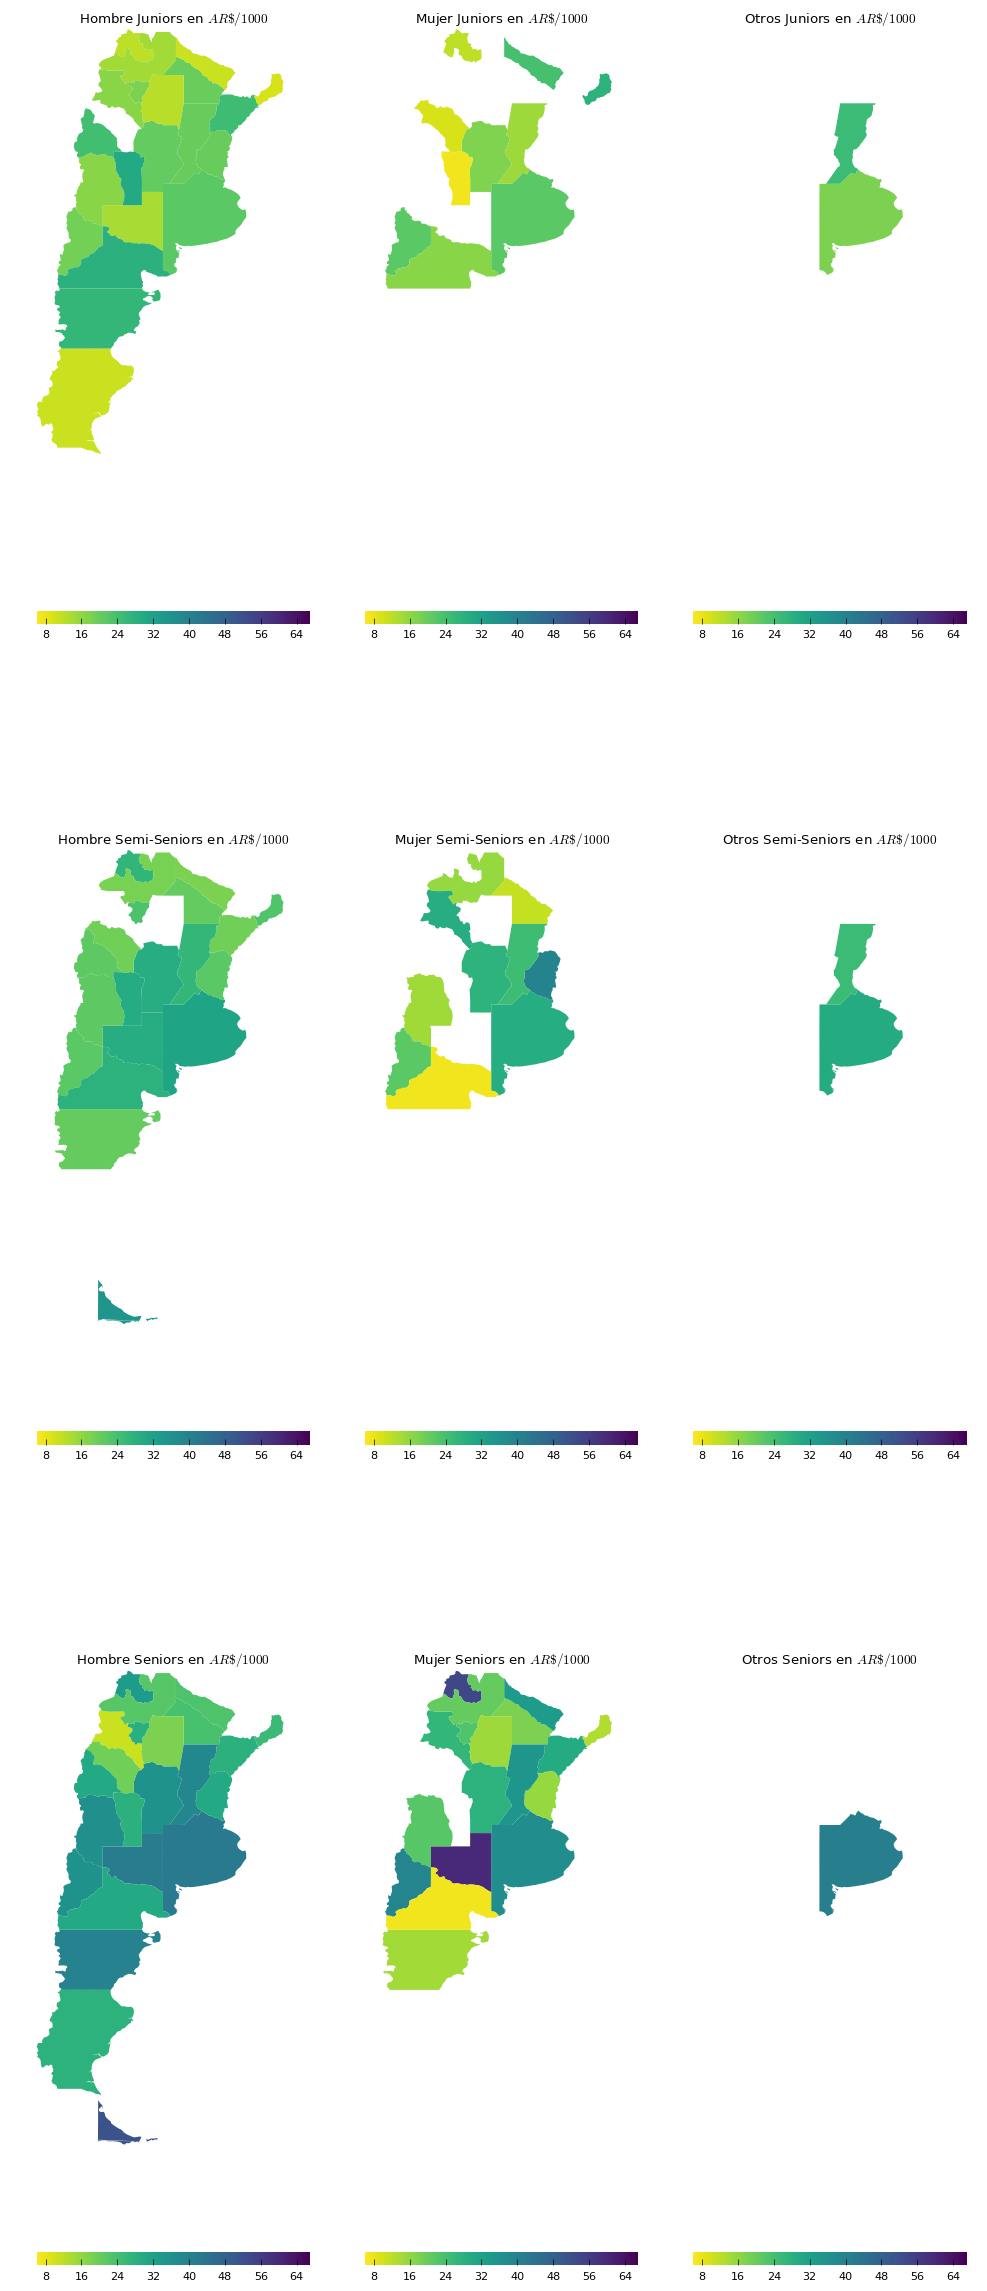

In [167]:
# define arbitrary ranges for seniority
yoes_jr = ['1 - 2', 'Menos de un año', '1', '2', '3']
yoes_ssr = ['3 - 5', '3', '4', '5', '6']
yoes_sr = ['5 - 7', '8 - 10', '5', '6', '7', '8', '9', '10', '10+']

yoes_ranges = [yoes_jr, yoes_ssr, yoes_sr]
yoes_ranges_names = ['Juniors', 'Semi-Seniors', 'Seniors']

def mapProvinceToSysarmyProvince(p):
    if p == 'Buenos Aires':
        return ['Ciudad Autónoma de Buenos Aires', 'GBA', 'Provincia de Buenos Aires']
    return [p]

plt.rcParams.update({'figure.figsize': (len(yoes_ranges)*4.0, len(genders)*10.0), 'font.size': 8})
fig, ax = plt.subplots(len(yoes_ranges), len(genders))

dfmaxx = df.salary.mean() + 1*df.salary.std()
dfminx = df.salary.min()
for i, gender in enumerate(genders):
    for j, yoe_range in enumerate(yoes_ranges):
        dfm = df.query('yoe in @yoe_range')
        dfmax = dfm.salary.mean() + 1*dfm.salary.std()
        patches = []
        colors = []
        for k, province in enumerate(provinces):
            points = polygons[k]
            polygon = Polygon(points, True)
            sysarmyProvince = mapProvinceToSysarmyProvince(province)
            dft = df.query('gender == @gender & yoe in @yoe_range & province in @sysarmyProvince')
            if len(dft) == 0:
                continue
            patches.append(polygon)
            color = dft.salary.median()/1000
            colors.append(color)
        colors.append(dfminx/1000)
        colors.append(dfmaxx/1000) # compensate scales across seniority

        p = PatchCollection(patches, cmap=cm.viridis_r, alpha=1, lw=0)
        ax[j][i].add_collection(p)
        ax[j][i].axis([0, 400, 800, 0])
        ax[j][i].set_axis_off()
        p.set_array(np.array(colors))
        cbar = fig.colorbar(p, ax=ax[j][i], orientation='horizontal')
        #cbar.ax.set_xticklabels(['Low', 'High'])
        cbar.outline.set_visible(False)
        ax[j][i].set_title('%s %s en $AR\$/1000$' % (gender, yoes_ranges_names[j]))
plt.show()